In [1]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 


from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

from keras import backend as K
from tensorflow.keras.models import Model
# ... other necessary imports ...


2024-01-31 06:01:17.564453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 06:01:17.564485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 06:01:17.565410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 06:01:17.570276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 06:01:18.474309: W tensorflow/compiler/tf2

In [2]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
#in this the output masks is of gray scal image hence the number channels is 1 
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)


In [3]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)# axis =-1 is used to add a single to end of the 
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

Resizing training images and masks


100%|██████████| 670/670 [03:31<00:00,  3.17it/s]


Resizing test images


100%|██████████| 65/65 [00:01<00:00, 58.20it/s]

Done!


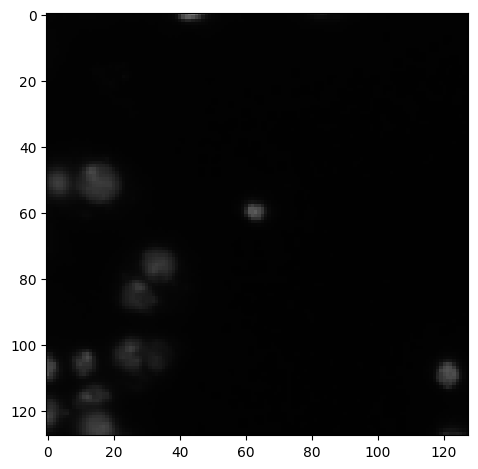

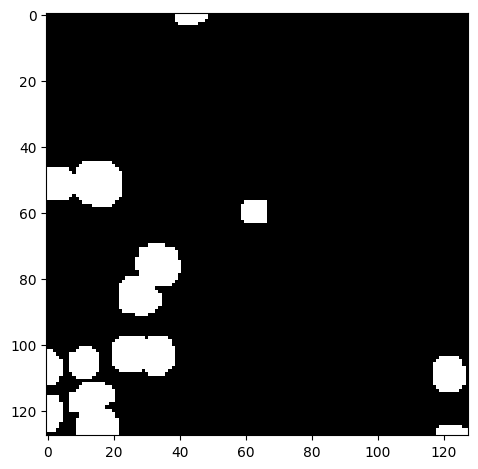

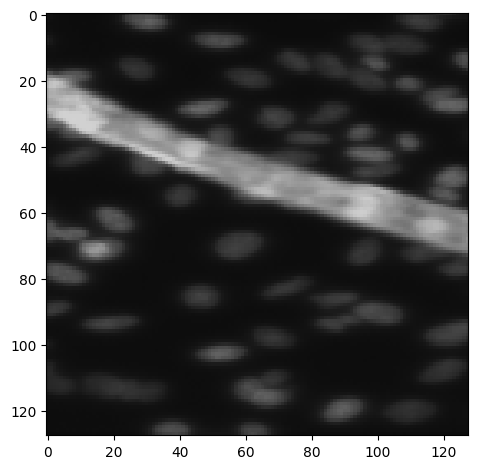

In [17]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
print('Done!')

image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()
imshow(X_test[image_x])
plt.show()



In [12]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

2024-01-31 14:35:25.545593: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-01-31 14:35:25.545619: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: pop-os
2024-01-31 14:35:25.545623: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: pop-os
2024-01-31 14:35:25.545725: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 545.29.6
2024-01-31 14:35:25.545740: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 545.29.6
2024-01-31 14:35:25.545744: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 545.29.6


In [13]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                              

                                                                                                  
 conv2d_6 (Conv2D)           (None, 16, 16, 128)          73856     ['max_pooling2d_2[0][0]']     
                                                                                                  
 dropout_3 (Dropout)         (None, 16, 16, 128)          0         ['conv2d_6[0][0]']            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 16, 16, 128)          147584    ['dropout_3[0][0]']           
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 128)            0         ['conv2d_7[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_8 

In [14]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 38s 932ms/step - loss: 0.5416 - accuracy: 0.7533 - val_loss: 0.3917 - val_accuracy: 0.7680
Epoch 2/25
38/38 [==============================] - 28s 739ms/step - loss: 0.2823 - accuracy: 0.8694 - val_loss: 0.2053 - val_accuracy: 0.9199
Epoch 3/25
38/38 [==============================] - 27s 699ms/step - loss: 0.1859 - accuracy: 0.9290 - val_loss: 0.1633 - val_accuracy: 0.9405
Epoch 4/25
38/38 [==============================] - 29s 764ms/step - loss: 0.1487 - accuracy: 0.9427 - val_loss: 0.1280 - val_accuracy: 0.9497
Epoch 5/25
38/38 [==============================] - 29s 758ms/step - loss: 0.1297 - accuracy: 0.9503 - val_loss: 0.1138 - val_accuracy: 0.9563
Epoch 6/25
38/38 [==============================] - 28s 747ms/step - loss: 0.1282 - accuracy: 0.9509 - val_loss: 0.1139 - val_accuracy: 0.9561
Epoch 7/25
38/38 [==============================] - 35s 936ms/step - loss: 0.1153 - accuracy: 0.9557 - val_loss: 0.1053 - val_accuracy: 0.9588

3/3 [==============================] - 1s 134ms/step


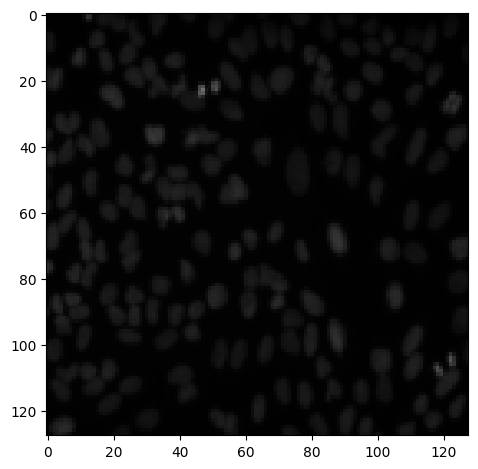

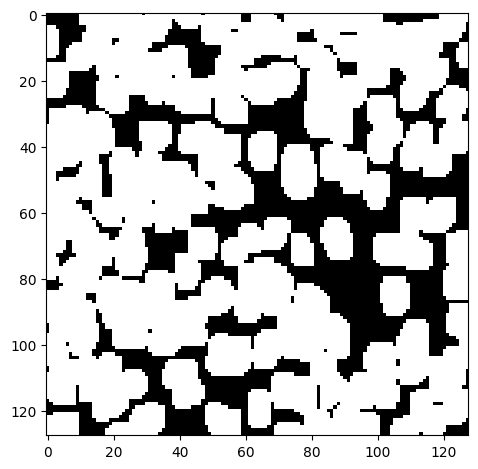

/home/vishwadharani/Code/U-net/uvenv/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


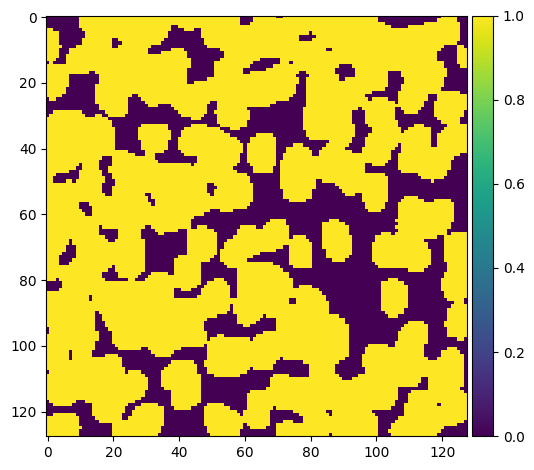

In [18]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()


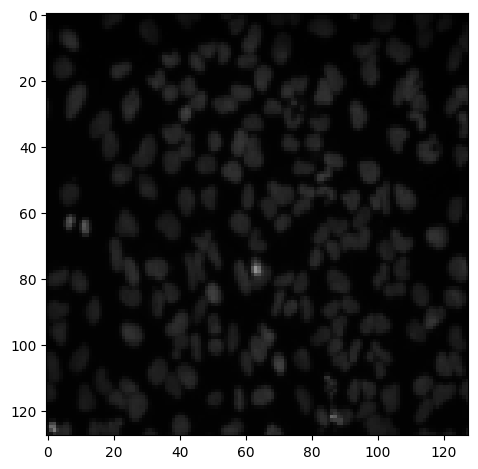

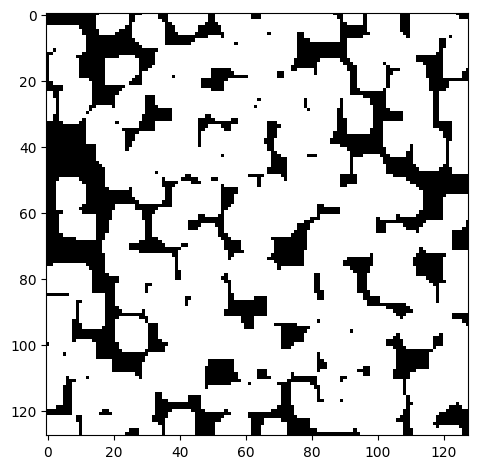

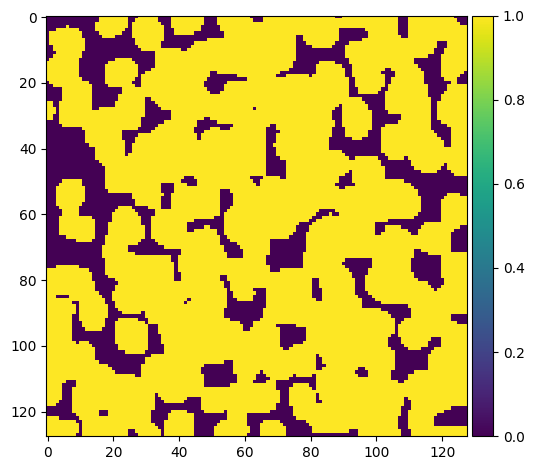

In [12]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Model # Assuming your model is a Keras Model
from skimage.io import imshow # For displaying images

In [14]:

def calculate_iou(y_true, y_pred):
    # Intersection: Element-wise min between true and pred masks
    intersection = np.logical_and(y_true, y_pred)
    # Union: Element-wise max between true and pred masks
    union = np.logical_or(y_true, y_pred)
    # Calculate IoU
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_scoren

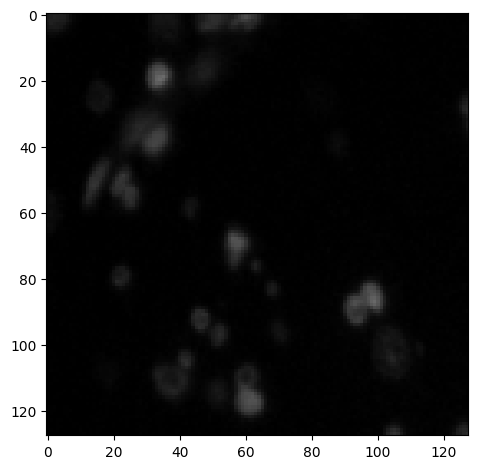

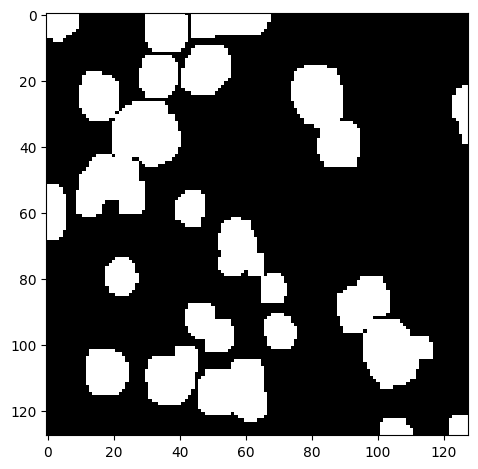

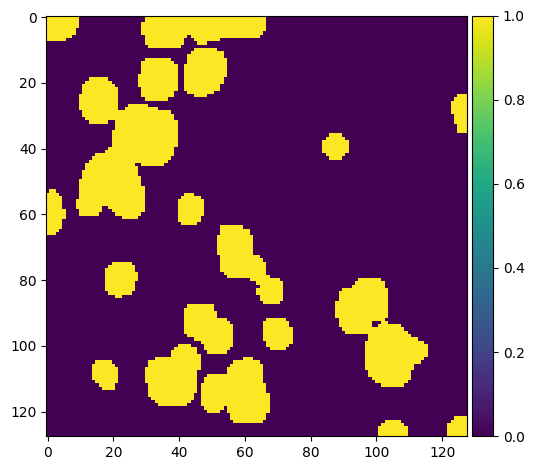

IoU Score: 0.7808349146110057


In [15]:
# Perform a sanity check on some random training samples
idx = random.randint(0, len(preds_train_t))
original_image = X_train[idx]
ground_truth_mask = np.squeeze(Y_train[idx])
predicted_mask = np.squeeze(preds_train_t[idx])

# Calculate IoU
iou_score = calculate_iou(ground_truth_mask, predicted_mask)

# Display the images and IoU score
imshow(original_image)
plt.show()
imshow(ground_truth_mask)
plt.show()
imshow(predicted_mask)
plt.show()
print(f"IoU Score: {iou_score}")

# he_normal

In [15]:
import numpy as np

# Parameters
fan_in = 9
stddev = np.sqrt(2 / fan_in)

# Generate weights for a 3x3 filter
weights = np.random.normal(0, stddev, (3, 3))

print(weights)

[[ 0.1001424   0.39177941 -0.66904947]
 [ 0.63920625 -0.08377689  0.28289043]
 [-0.07392359 -0.0442864   0.21902912]]


# dropoutlayers


In [25]:
A=[
 [1, 2, 3, 4, 5, 6],
 [2, 3, 4, 5, 6, 7],
 [3, 4, 5, 6, 7, 8],
 [4, 5, 6, 7, 8, 9],
 [5, 6, 7, 8, 9, 10],
 [6, 7, 8, 9, 10, 11]
]

# IOU Calculation

In [19]:

# Ground truth mask
y_true = np.array([[0, 1, 1],
                   [0, 0, 1],
                   [1, 1, 0]])

# Predicted mask
y_pred = np.array([[0, 1, 0],
                   [0, 0, 1],
                   [1, 0, 0]])


In [20]:
intersection = np.logical_and(y_true, y_pred)
# Resulting intersection mask
# [[0, 1, 0],
#  [0, 0, 1],
#  [1, 0, 0]]

In [21]:
union = np.logical_or(y_true, y_pred)
# Resulting union mask
# [[0, 1, 1],
#  [0, 0, 1],
#  [1, 1, 0]]

iou_score = np.sum(intersection) / np.sum(union)
# IoU = (1 + 1 + 1) / (2 + 1 + 2) = 3 / 5 = 0.6

In [23]:
np.sum(union)

5

In [22]:
iou_score

0.6